In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import Config
from matplotlib.colors import LogNorm

In [2]:
# This checks whether or not the user wants to use the default values
default = input('Do you want to use default values?\nResolution: 4096' + 
                  '\nNumber of bins: 10\nPercent of variance captured: 0.98\nDegree of fits: 1' + 
                  '\nPercent of PC maps used: 0.625\nUnable to break out of fitting early\n' + 
                  'Computer will not adaptively find best degree for fit\nY/N:')

# This insures that the value is valid (case insensitive)
while (default != 'y') and (default != 'Y') and (default != 'n') and (default != 'N'):
    default = input('Please enter \'Y\' for yes or \'N\' for no:')
    
if (default == 'y') or (default == 'Y'):
    default = True
else:
    default = False

Do you want to use default values?
Resolution: 4096
Number of bins: 10
Percent of variance captured: 0.98
Degree of fits: 1
Percent of PC maps used: 0.625
Unable to break out of fitting early
Computer will not adaptively find best degree for fit
Y/N: N


In [3]:
if default:
    res = 4096 # Resolution of the heal pixels
    numBins = 10 # Number of bins in fitting
    perVar = 0.98 # Percent of the variance to be captured
    perMap = 0.625 # Percent of the PC maps to use, adjust this later
    breakAbility = False # Whether or not you can break out early
    autoDegree = False # Whether or not the computer will adaptively figure out the degree
    degree = 1 # Degree the fit wll be
else:
    # This gets the resolution and insures that it is a valid number
    res = input('Enter NSIDE resolution (must be a power of 2, default is 4096):')

    while (not res.isdigit()) or (int(res) <= 0) or (2**int(np.log2(int(res))) != int(res)):
        res = input('Please enter valid resolution:')

    res = int(res)
    
    # This gets the number of bins and insures that it is a valid number
    numBins = input('Enter number of bins (default is 10):')

    while (not numBins.isdigit()) or (int(numBins) <= 0):
        numBins = input('Please enter positive integer:')

    numBins = int(numBins)
    
    # This gets the percent of variance to capture and insures that it is a valid float
    perVar = input('Enter fraction of variance to capture (between 0 and 1, default is 0.98):')

    validValue = True

    try:
        float(perVar)
        if (float(perVar) > 1) or (float(perVar) < 0):
            validValue = False
    except ValueError:
        validValue = False

    while not validValue:
        perVar = input('Please enter valid fraction:')

        validValue = True

        try:
            float(perVar)
            if (float(perVar) > 1) or (float(perVar) < 0):
                validValue = False
        except ValueError:
            validValue = False

    perVar = float(perVar)
    
    # This checks whether or not to let the software automatically figure out the degree to fit curves to
    autoDegree = input('Do you want the computer to automatically find the best fit\n' + 
                       'between degrees one and 5? Y/N:')
    
    while (autoDegree != 'y') and (autoDegree != 'Y') and (autoDegree != 'n') and (autoDegree != 'N'):
        autoDegree = input('Please enter \'Y\' for yes or \'N\' for no: ')

    if (autoDegree == 'y') or (autoDegree == 'Y'):
        autoDegree = True
        
        degree = 10 # These should never get used, just filling in for values rn.
        breakAbility = False
    else:
        autoDegree = False
        
    if autoDegree: # You'd need to tell the program here where to terminate in terms of how many PC Maps to use
        perMap = input('Enter fraction of PC maps to use (between 0 and 1, default is 0.625):')

        validValue = True

        try:
            float(perMap)
            if (float(perMap) > 1) or (float(perMap) < 0):
                validValue = False
        except ValueError:
            validValue = False

        while not validValue:
            perMap = input('Please enter valid fraction:')

            validValue = True

            try:
                float(perMap)
                if (float(perMap) > 1) or (float(perMap) < 0):
                    validValue = False
            except ValueError:
                validValue = False

        perMap = float(perMap)
    else:
        # Checks if they want to interactively determine the degrees of fits.
        breakAbility = input('Do you want to interactively determine the degrees of fits?\n' + 
                          'Since this requires you to stay at the keyboard, you will also\n' + 
                          'have the ability to choose in real time when to end fitting. Y/N:')

        while (breakAbility != 'y') and (breakAbility != 'Y') and (breakAbility != 'n') and (breakAbility != 'N'):
            breakAbility = input('Please enter \'Y\' for yes or \'N\' for no: ')

        if (breakAbility == 'y') or (breakAbility == 'Y'):
            breakAbility = True

            degree = 10 # These should never get used, just filling in for values rn.
            perMap = 0.01
        else:
            breakAbility = False

        if not breakAbility:
            degree = input('Enter fit degree (default is 1):')

            while (not degree.isdigit()) or (int(degree) <= 0):
                degree = input('Please enter positive integer:')

            degree = int(degree)

            perMap = input('Enter fraction of PC maps to use (between 0 and 1, default is 0.625):')

            validValue = True

            try:
                float(perMap)
                if (float(perMap) > 1) or (float(perMap) < 0):
                    validValue = False
            except ValueError:
                validValue = False

            while not validValue:
                perMap = input('Please enter valid fraction:')

                validValue = True

                try:
                    float(perMap)
                    if (float(perMap) > 1) or (float(perMap) < 0):
                        validValue = False
                except ValueError:
                    validValue = False

            perMap = float(perMap)

Enter NSIDE resolution (must be a power of 2, default is 4096): 4096
Enter number of bins (default is 10): 10
Enter fraction of variance to capture (between 0 and 1, default is 0.98): 0.98
Do you want the computer to automatically find the best fit
between degrees one and 5? Y/N: y
Enter fraction of PC maps to use (between 0 and 1, default is 0.625): 0.625


## Naming Convention

WME - Weighted Mean

MIN - Minimum

MAX - Maximum

SUM - Sum

QSU - QSum

UNC - Uncertainty

In [4]:
# This is the actual file containing all of the data
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are detected, true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])

In [5]:
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# This is used for detection rates, each point is either a 0 (no detection) or a 1 (detection)
DETECTED = starData['detected']
# Everything from here on out is simply used in order to filter the data
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2))[0]

# This reduced the data down to the actually valid pixels.
DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [6]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

In [7]:
# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPixels.argsort()
starPix = starPixels[sortInds[::1]]
DET = DETECTED[sortInds[::1]]

In [8]:
# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
pixStar = np.unique(starPix) # The unique pixels, with no repeats.
detStar = np.zeros_like(pixStar)
injStar = np.zeros_like(pixStar)

while starInd < len(starPix):
    if pixStar[uniqInd] == starPix[starInd]: # If the pixels match up in the arrays.
        detStar[uniqInd] += DET[starInd]     # Add one if there was a detection at this location.
        injStar[uniqInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
        
# This loads in all of the file names of the survey conditions
condFiles = Config.files
condMapsExt = []

# This loops over every condition file except for stellar density which has a different format
for i in range(len(condFiles) - 1):
    condData = fitsio.read(condFiles[i]) # This reads in the data
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals
    condSigExt[np.where(condSigExt == -1.6375e+30)[0]] = hp.UNSEEN # Masks all non valid pixels
    if res != 4096:
        condSigExt=hp.ud_grade(condSigExt, res) # Only degrades if necessary (this is very time consuming)
    condMapsExt.append(condSigExt[pixStar]) # Only stores the values that are in pixels with injections
    
stelDensExt = fitsio.read(condFiles[-1])['I'].flatten() # Loads in the stellar density
stelDensExt[np.where(stelDensExt < 0)[0]] = hp.UNSEEN # Masks all non valid pixels
if res != 4096:
    stelDensExt=hp.ud_grade(stelDensExt, res) # Degrades if necessary
condMapsExt.append(stelDensExt[pixStar])

condMapsExt = np.array(condMapsExt, dtype = object) # Converts to an array

validIndices = np.full(len(pixStar), True, dtype = bool)
# The only valid indices are ones where every survey property is unmasked
for cond in condMapsExt:
    tempValidIndices = np.full(len(pixStar), True, dtype = bool)
    tempValidIndices[np.where(cond < -1000000000)[0]] = False
    validIndices = validIndices & tempValidIndices
    
condMaps = []
# Degrades all of the values to a common set of pixels
pixStar = pixStar[validIndices]
detStar = detStar[validIndices]
injStar = injStar[validIndices]

for cond in condMapsExt:
    condMaps.append(cond[validIndices])
    
condMaps = np.array(condMaps)

In [9]:
stanMaps = []
averages = []
stanDevs = []
# This standardizes every map as a first step of PCA
for cond in condMaps:
    averages.append(np.average(cond))
    stanDevs.append(np.std(cond))
    stanMaps.append((cond - np.average(cond)) / np.std(cond))
    
stanMaps = np.array(stanMaps)

In [10]:
# This gives the covariance matrix of the standardized maps
# Bias is true since the variance of each individual standardized map should be 1
cov = np.cov(stanMaps.astype(float), bias = True)

In [11]:
# This gives the eigenvalues and vectors of the covariance matrix
evalues, evectors = np.linalg.eig(cov)

In [12]:
# sigValues = [0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 1]

# for i in range(len(evalues)):
#     if np.sum(evalues[0:i+1])/np.sum(evalues) >= sigValues[0]:
#         print('Total variance captured of '+format(100*np.sum(evalues[0:i+1])/np.sum(evalues),'.1f')+'% after '+str(i+1)+' eigenvalues.')
#         sigValues.pop(0)
#     if len(sigValues) == 0:
#         break

In [13]:
# This cuts after the specified percentage of the variance has been achieved
for i in range(len(evalues)):
    if np.sum(evalues[0:i+1]) / np.sum(evalues) >= perVar:
        cutoff = i + 1
        break
featVec = evectors[0:cutoff]

In [14]:
redMaps = np.matmul(featVec, stanMaps) # Reduces the maps to PCA maps

In [15]:
# Stores the original data for later comparisons
originalDetStar = detStar
originalInjStar = injStar
aveEff = np.sum(originalDetStar) / np.sum(originalInjStar)

# General Algorithm

In [16]:
def getFitParams(index, redMaps, detStar, injStar = injStar, numBins = numBins, fitDegree = degree):
    
    onePC = redMaps[index] # This loads up the PC Map we'll be using
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))
        
    # This gives the limits (in index) of the bins

    # Sorts the data according to the value of the PC map
    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    # Generates the bins
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    # The x values are a weighted average of the PC values with weights in terms of how many injections were on that pixel
    # The y values are the detection rate relative to theaverage efficiency
    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    # This fits the data to a polynomial of specified degree
    p = np.polyfit(xValues, yValues, fitDegree)
    
    return p

In [17]:
def plotFit(index, redMaps, detStar, size = 100, injStar = injStar, numBins = numBins, fitDegree = degree):
    
    onePC = redMaps[index]
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    p = np.polyfit(xValues, yValues, fitDegree)
    # Up until this point, the method is identical to the one above
    
    yFitValues = np.zeros_like(xValues)
    
    # Here we generate what the fit values are going to be
    for i in range(len(p)):
        yFitValues += p[i] * (xValues**(len(p) - 1 - i))

    # This plots out the data and fit line
    plt.figure(dpi = size)
    plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4, label = 'Data')
    plt.axhline(y = 1,color = 'k', linestyle = '--', zorder = 2)
    plt.plot(xValues, yFitValues, zorder = 3, label = 'Fit')
    plt.legend()
    plt.xlabel('PC Value')
    plt.ylabel('N/⟨N⟩')
    plt.title('Degree ' + str(len(p) - 1) + ' Fit, Index ' + str(index))
    plt.grid(zorder = 0)
    plt.show()
    
    # This returns the fit parameters
    return p

In [18]:
# This method does the same thing as the one above it but doesn't plot out a fit line.
# As well as this, no parameters are returned since no fit was performed.
def plotNoFit(index, redMaps, detStar, size = 100, injStar = injStar, numBins = numBins):
    
    onePC = redMaps[index]
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)

    plt.figure(dpi = size)
    plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4)
    plt.axhline(y = 1,color = 'k', linestyle = '--', zorder = 2)
    plt.xlabel('PC Value')
    plt.ylabel('N/⟨N⟩')
    plt.title('Detection Rate vs PC Map Value')
    plt.grid(zorder = 0)
    plt.show()

In [19]:
# Goal of this method is to find the index of the map that has the largest impact on detection rates.
def mostSigPCMap(redMaps, detStar, injStar = injStar, numBins = numBins):
    
    maxAdjustment = []

    for i in range(len(redMaps)):
        
        onePC = redMaps[i] # Load up a PC map

        binIndLims = [0]

        for j in range(numBins):
            binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

        # Sort detections and injections by the PC map value.
        sortInds = onePC.argsort()
        detStarTemp = detStar[sortInds[::1]]
        injStarTemp = injStar[sortInds[::1]]

        detBins = []
        injBins = []

        # Bin up these detections and injections.
        for j in range(numBins):
            detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
            injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])

        yValues = []

        # For each bin find the detection rate relative to the average.
        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        # Make the error the sum of the squared difference between the binned values and 1.
        maxAdjustment.append(np.sum((yValues - 1)**2))
        
    maxAdjustment = np.array(maxAdjustment)
    
    mostSigIndex = np.where(maxAdjustment == np.max(maxAdjustment))[0]
    
    return mostSigIndex[0] # Return wherever the error is the largest

In [20]:
# Goal is to find the best degree for fitting the data between one and five.
def findBestDegree(index, redMaps, detStar, injStar = injStar, numBins = numBins):
    
    onePC = redMaps[index] # Load up a PC map

    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    # Sort detections and injections by the PC map value.
    sortInds = onePC.argsort()
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []

    # Bin up these detections and injections.
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])

    yValues = []

    # For each bin find the detection rate relative to the average.
    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

    yValues = np.array(yValues)

    initialError = np.sum((yValues - 1)**2)
    
    # Gives the errors at each fit
    errors = []
    
    for potDegrees in (np.arange(5) + 1): # Potential degrees between 1 and 5
        
        tempDetStar = np.copy(detStar)
        
        fitParams = getFitParams(index, trimRedMaps, detStar, fitDegree = potDegrees)
        
        correction = np.full(len(detStar), 0.0)
            
        for i in range(len(fitParams)):
            correction = correction + (fitParams[i] * (redMaps[index]**(len(fitParams) - 1 - i)))
                
        correction = 1 / correction
        
        tempDetStar = tempDetStar * correction # Apply the correction at the certain degree
        
        onePC = redMaps[index]
    
        binIndLims = [0]

        for j in range(numBins):
            binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

        sortInds = onePC.argsort()
        detStarTemp = tempDetStar[sortInds[::1]]
        injStarTemp = injStar[sortInds[::1]]

        detBins = []
        injBins = []

        for j in range(numBins):
            detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
            injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])

        yValues = []

        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        errors.append(np.sum((yValues - 1)**2)) # See how far off the calculated y Values are
        
    errors = np.array(errors)
        
    return (np.where(errors == np.min(errors))[0] + 1), initialError

## Trying Out Correction Procedure

In [21]:
detStar = originalDetStar

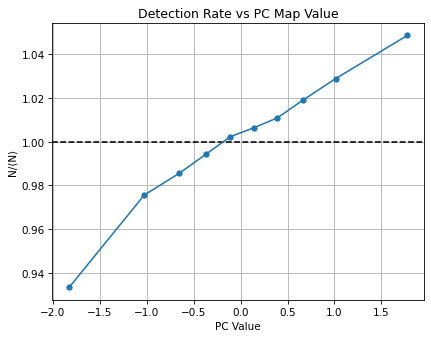

[3]


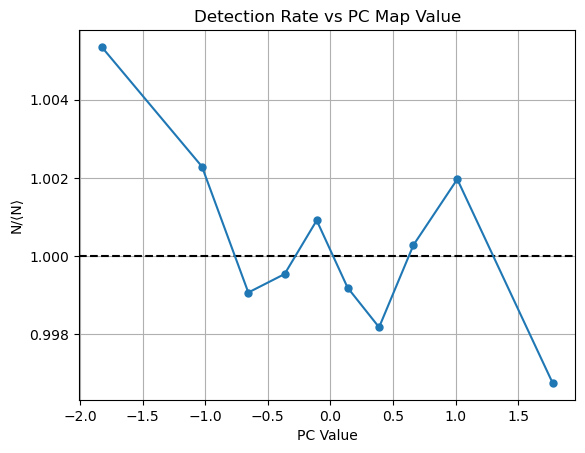

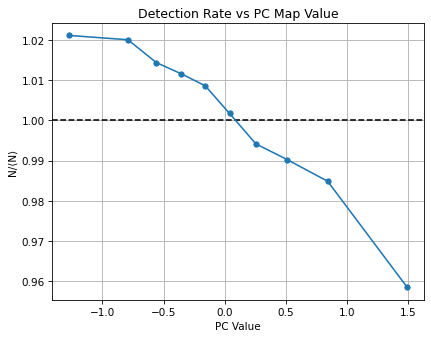

[2]


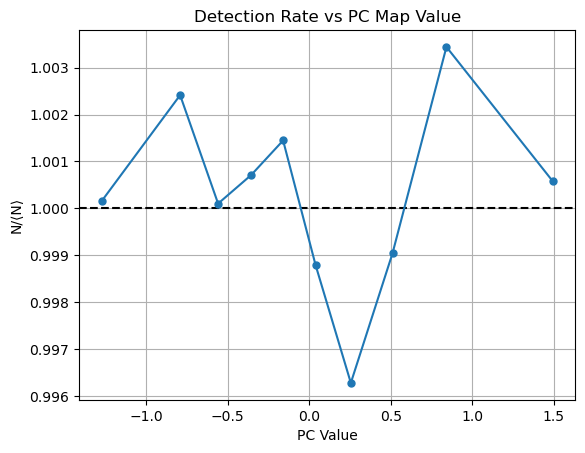

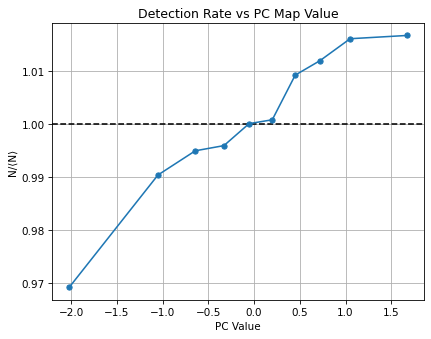

[2]


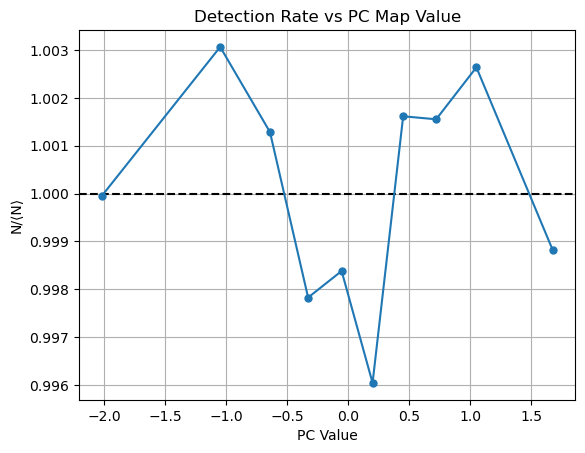

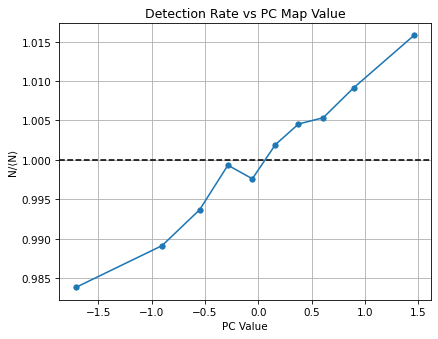

[3]


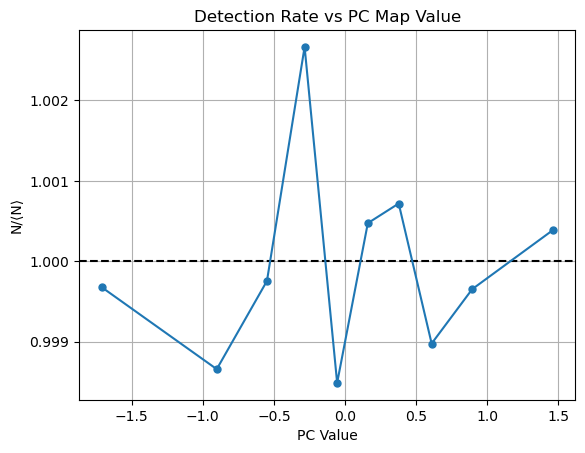

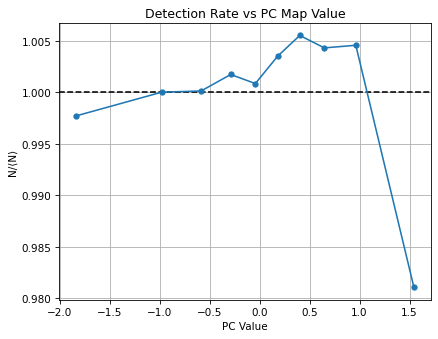

[3]


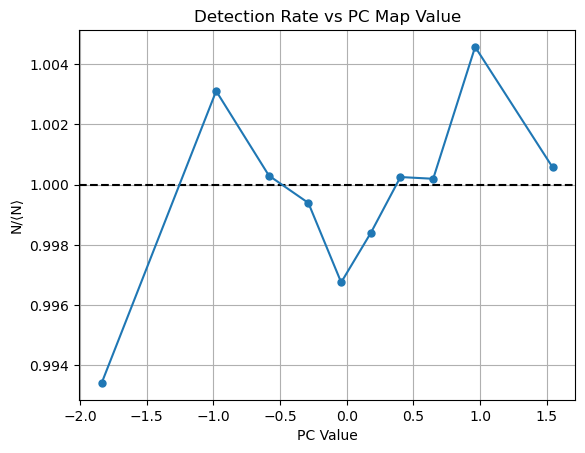

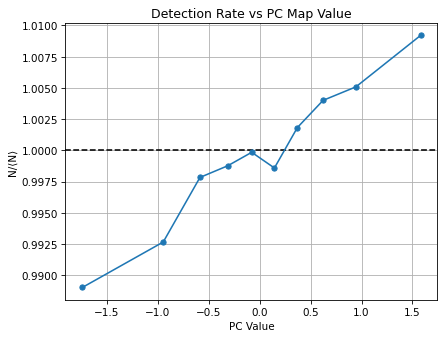

[2]


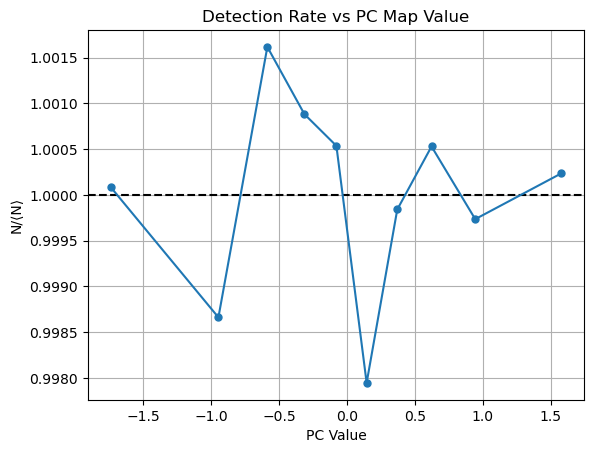

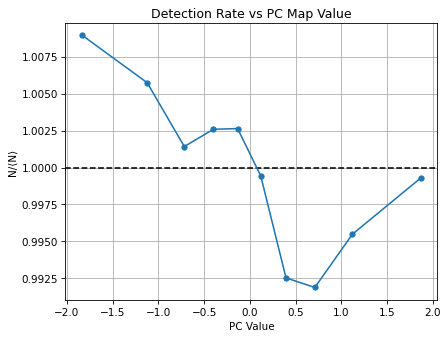

[3]


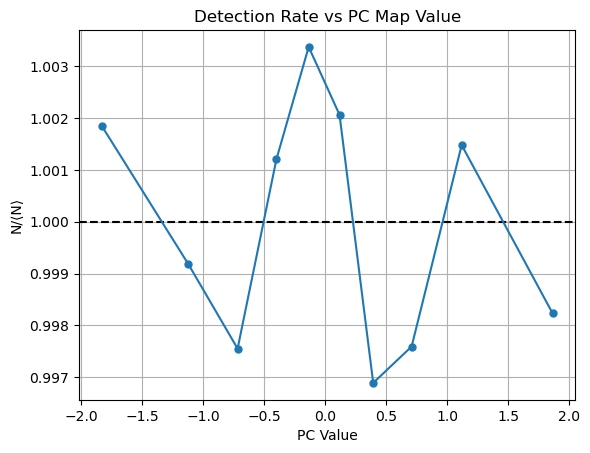

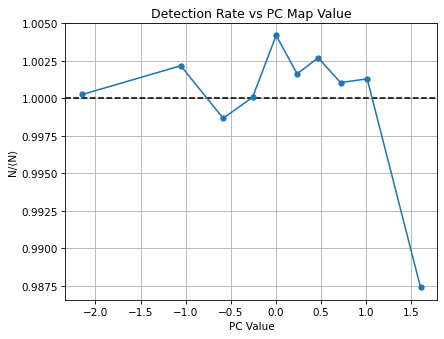

[3]


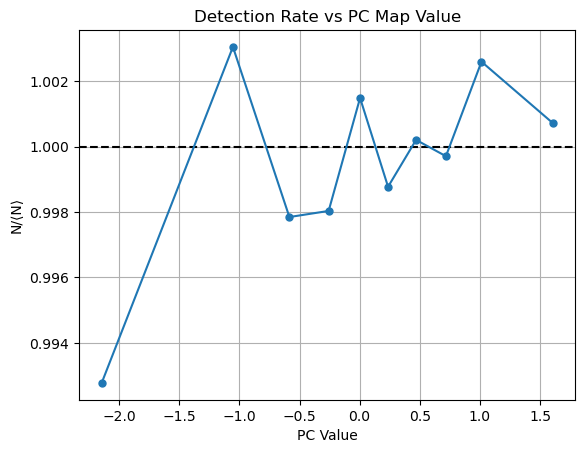

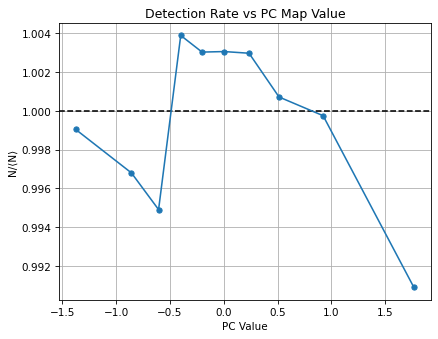

[2]


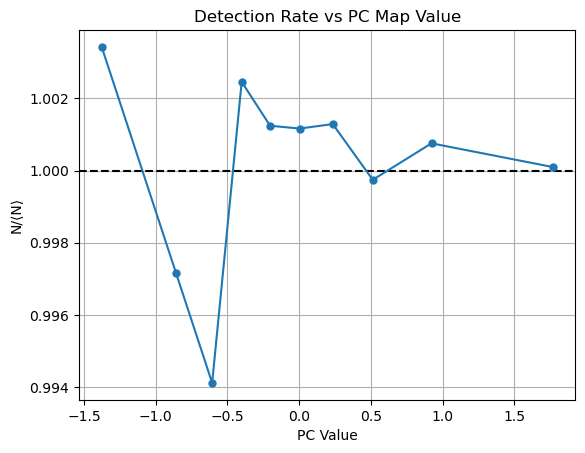

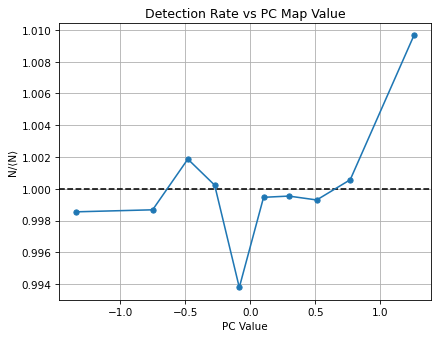

[5]


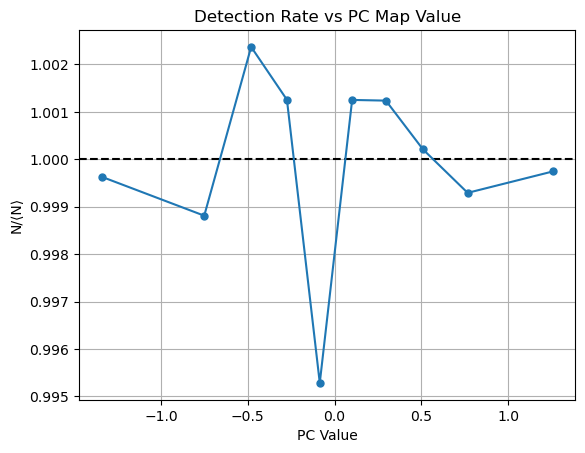

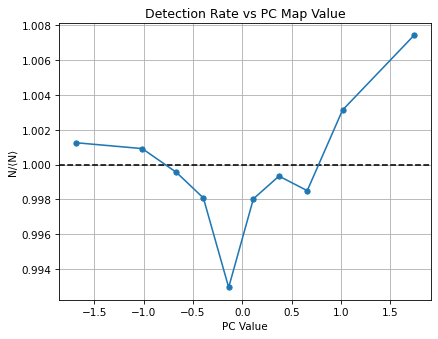

[3]


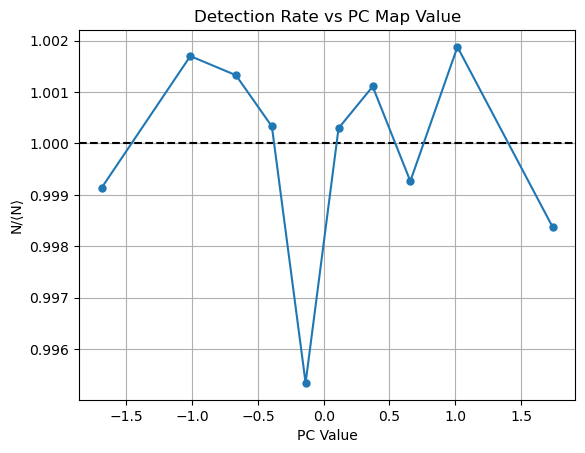

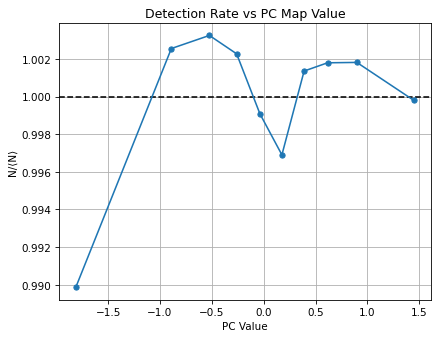

[2]


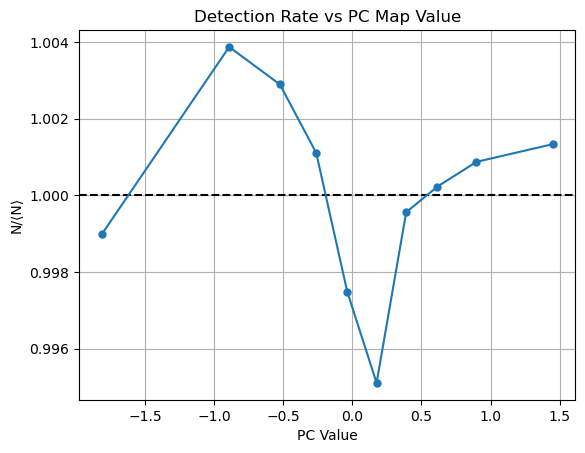

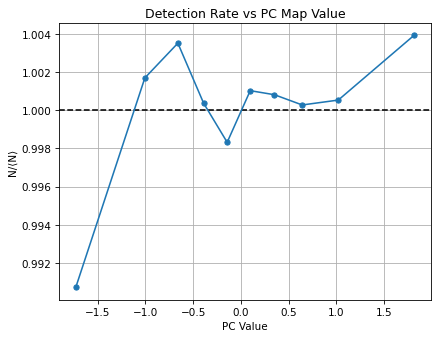

[3]


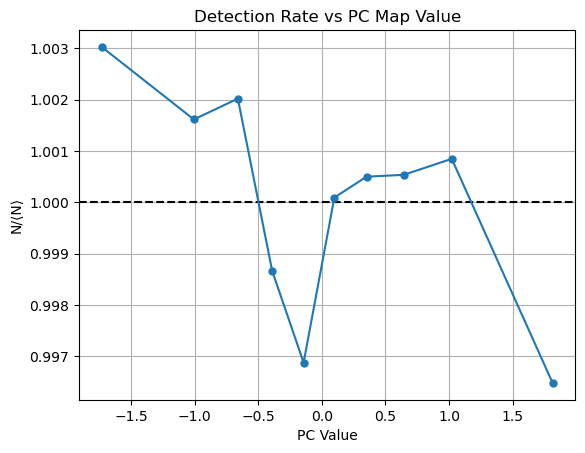

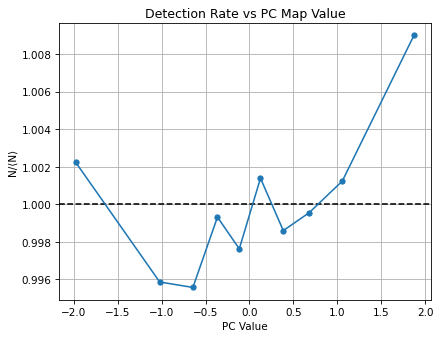

[3]


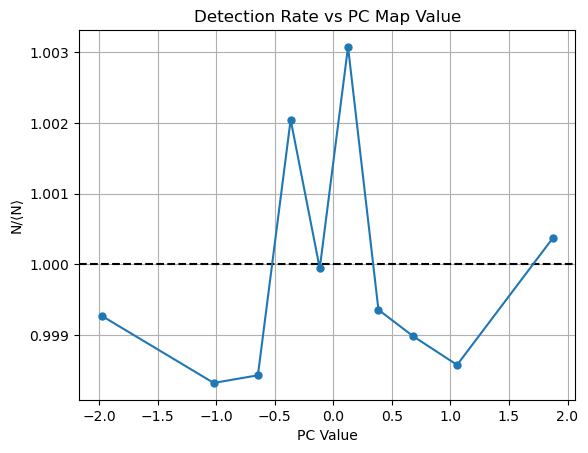

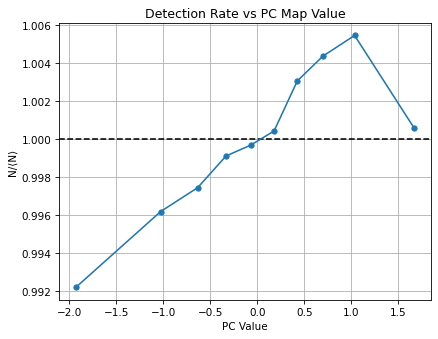

[3]


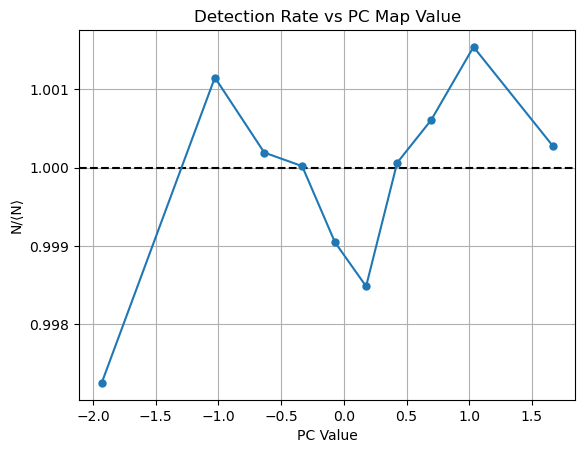

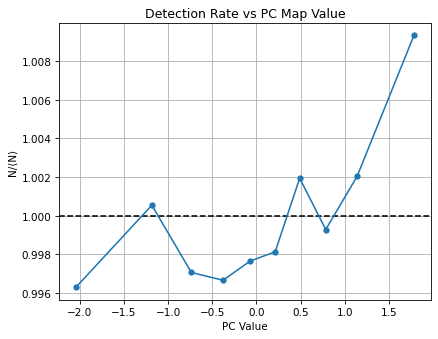

[3]


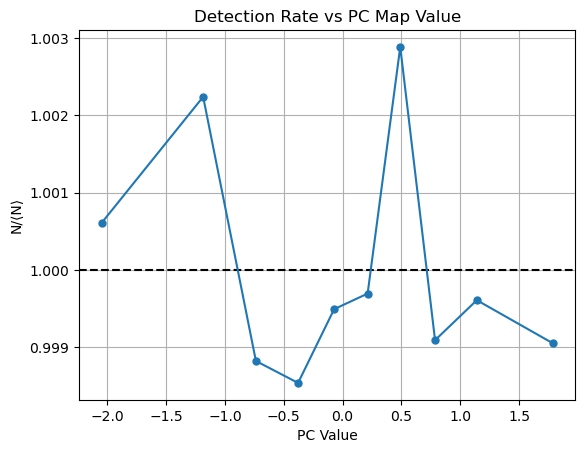

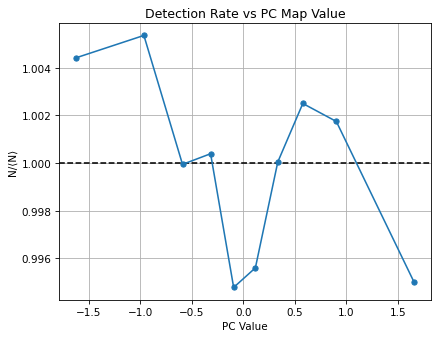

[3]


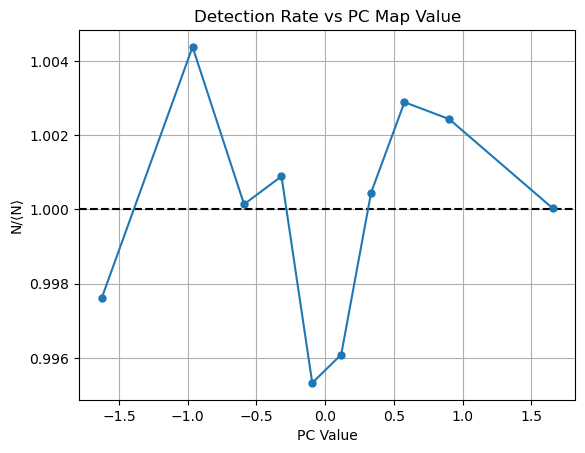

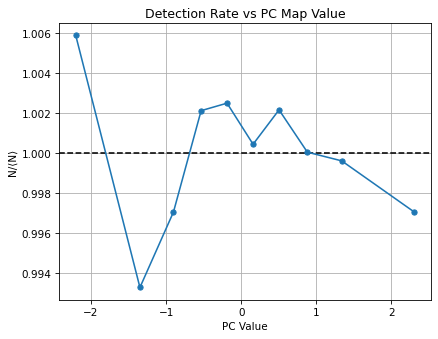

[3]


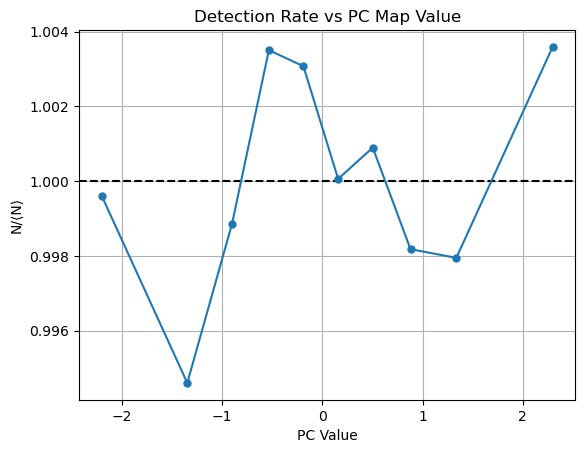

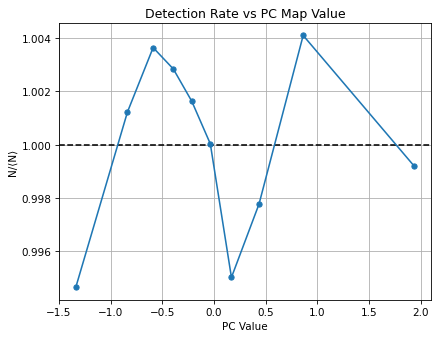

[3]


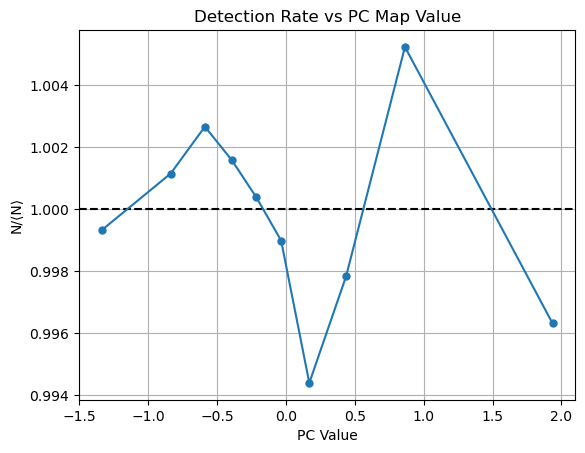

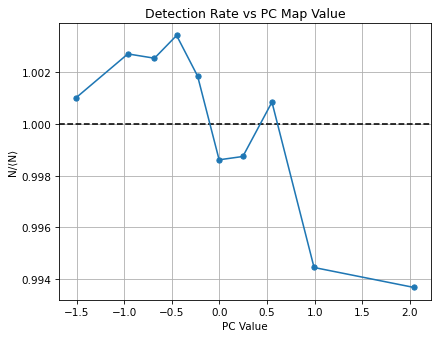

[3]


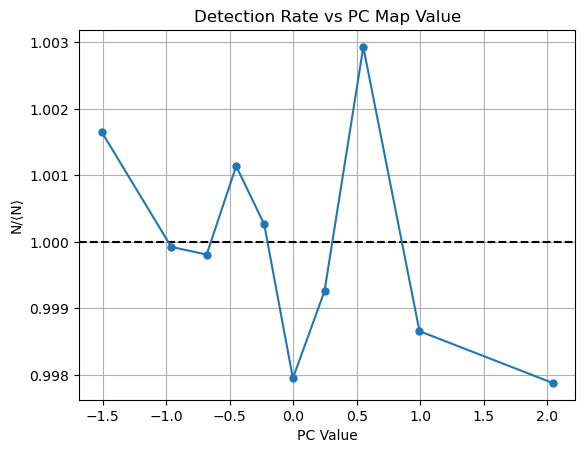

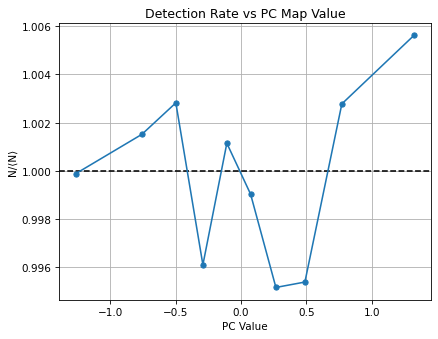

[3]


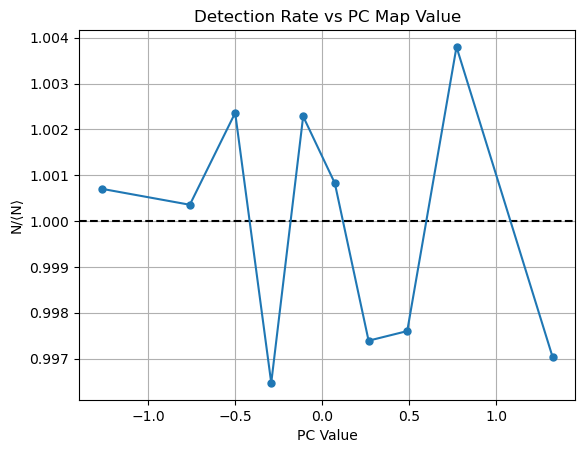

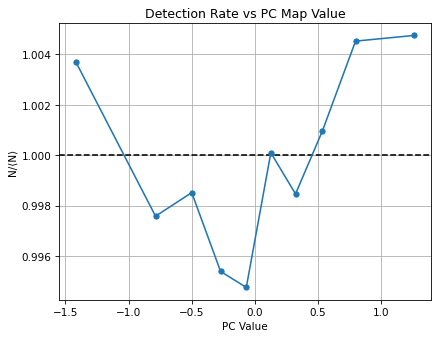

[3]


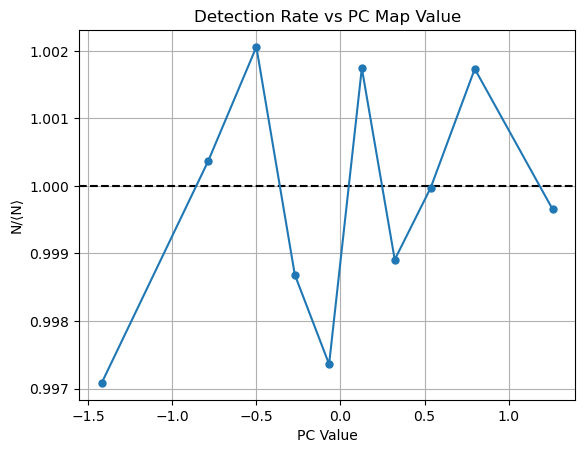

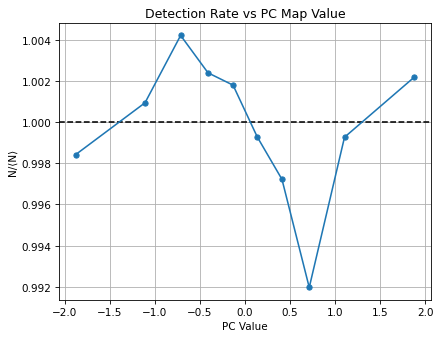

[4]


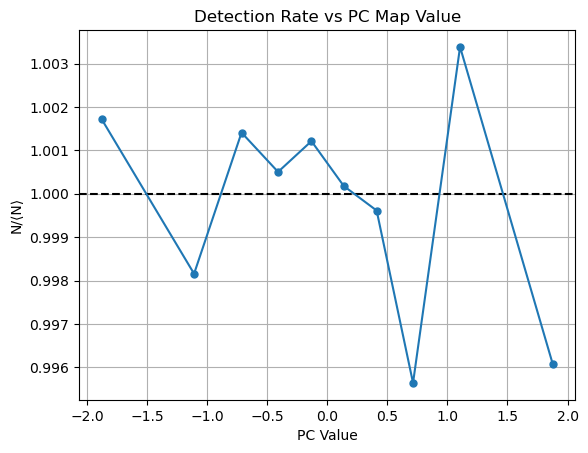

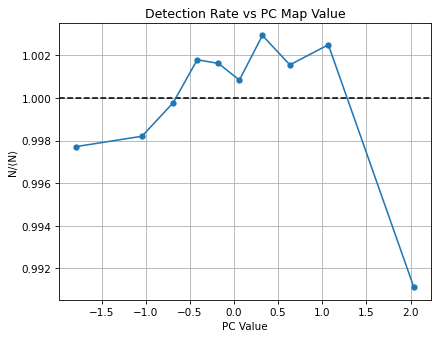

[3]


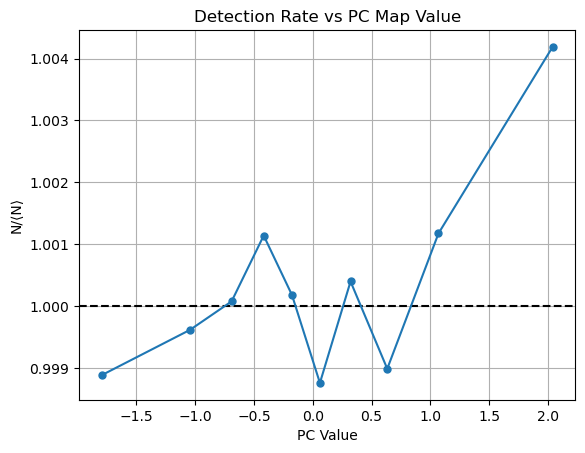

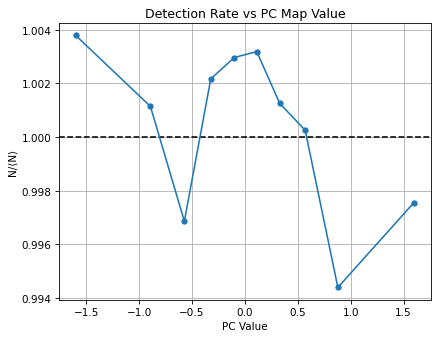

[2]


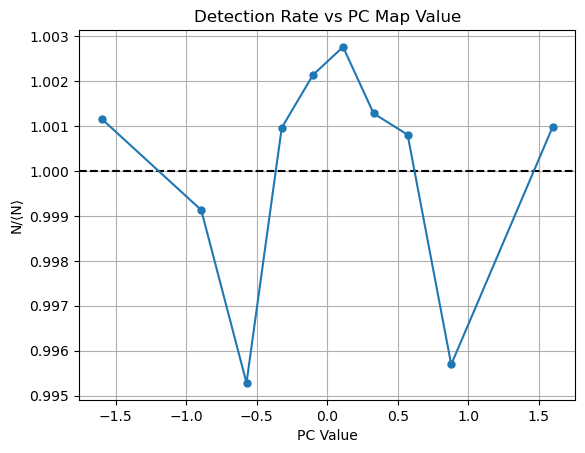

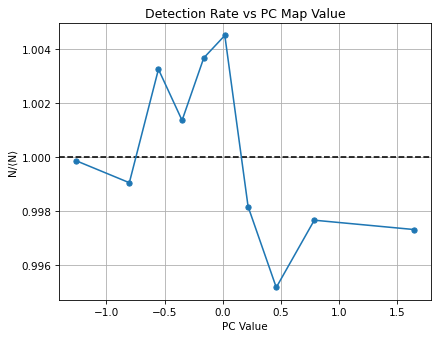

[3]


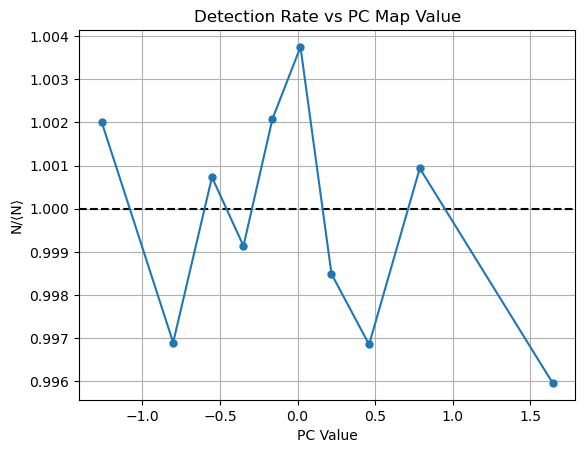

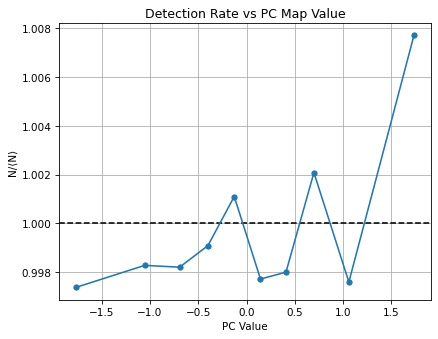

[3]


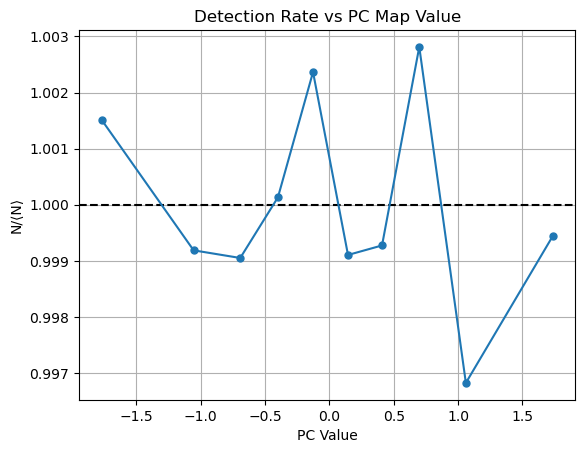

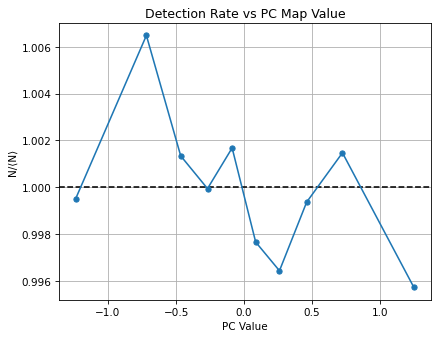

[3]


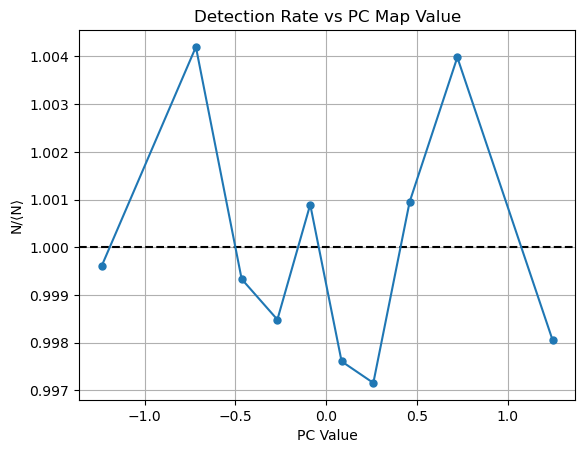

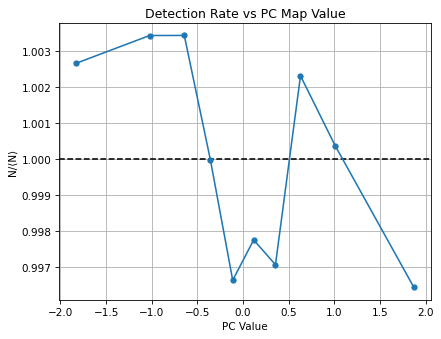

[3]


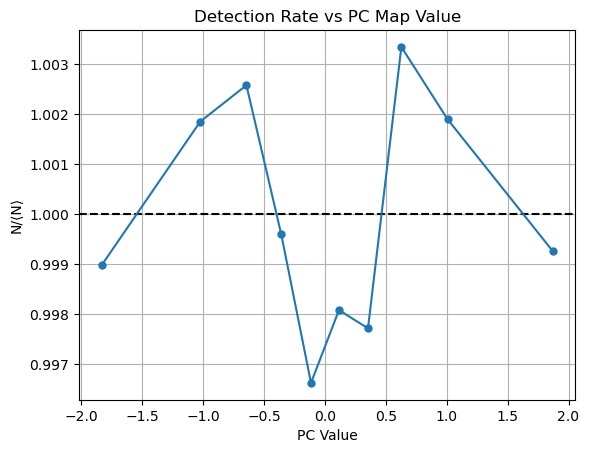

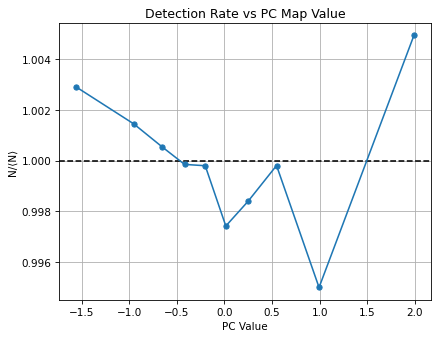

[3]


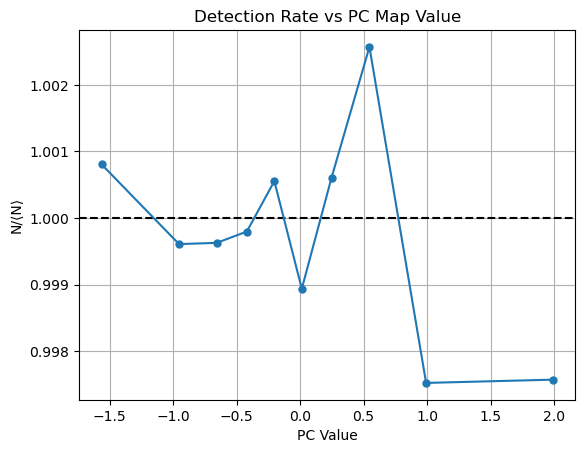

In [22]:
trimRedMaps = np.copy(redMaps)

iterations = int(perMap * len(redMaps))

if autoDegree:
    
    allErrors = []
    
    for _ in range(iterations):
        
        index = mostSigPCMap(trimRedMaps, detStar)
        
        degree, error = findBestDegree(index, trimRedMaps, detStar)
        
        allErrors.append(error)
        
        plotNoFit(index, trimRedMaps, detStar, size = 75)
        print(degree)
        
        fitParams = getFitParams(index, trimRedMaps, detStar, fitDegree = degree)
        
        correction = np.full(len(detStar), 0.0)
            
        for i in range(len(fitParams)):
            correction = correction + (fitParams[i] * (trimRedMaps[index]**(len(fitParams) - 1 - i)))
                
        correction = 1 / correction
        
        detStar = detStar * correction
        
        plotNoFit(index, trimRedMaps, detStar)

        pcMapCutoff = np.full(len(trimRedMaps), True, dtype = bool)
        pcMapCutoff[index] = False
        trimRedMaps = trimRedMaps[pcMapCutoff]
        
    allErrors = np.array(allErrors)
        
elif not breakAbility:
    for _ in range(iterations):

        index = mostSigPCMap(trimRedMaps, detStar)
        fitParams = getFitParams(index, trimRedMaps, detStar)
        # fitParams = plotFit(index, trimRedMaps, detStar)
        
        correction = np.full(len(detStar), 0.0)
            
        for i in range(len(fitParams)):
            correction = correction + (fitParams[i] * (trimRedMaps[index]**(len(fitParams) - 1 - i)))
                
        correction = 1 / correction

        detStar = detStar * correction
        # plotNoFit(index, trimRedMaps, detStar)

        pcMapCutoff = np.full(len(trimRedMaps), True, dtype = bool)
        pcMapCutoff[index] = False
        trimRedMaps = trimRedMaps[pcMapCutoff]
        
else:
    continueFitting = True
    forceEnd = False
    
    while (continueFitting) and (not forceEnd):
        if len(trimRedMaps) == 1:
            forceEnd = True
        
        index = mostSigPCMap(trimRedMaps, detStar)
        plotNoFit(index, trimRedMaps, detStar, size = 75)
        
        desiredFit = False
        
        while not desiredFit:
        
            degree = input('Enter fit degree:')

            while (not degree.isdigit()) or (int(degree) <= 0):
                degree = input('Please enter positive integer:')

            degree = int(degree)
            
            fitParams = plotFit(index, trimRedMaps, detStar, fitDegree = degree, size = 75)
            
            correction = np.full(len(detStar), 0.0)
            
            for i in range(len(fitParams)):
                correction = correction + (fitParams[i] * (trimRedMaps[index]**(len(fitParams) - 1 - i)))
                
            correction = 1 / correction
            
            theoreticalDetStar = detStar * correction
            plotNoFit(index, trimRedMaps, theoreticalDetStar, size = 75)
            
            desiredFit = input('Is this your desired fit and correction? Y/N:')

            while (desiredFit != 'y') and (desiredFit != 'Y') and (desiredFit != 'n') and (desiredFit != 'N'):
                desiredFit = input('Please enter \'Y\' for yes or \'N\' for no: ')

            if (desiredFit == 'y') or (desiredFit == 'Y'):
                desiredFit = True
                detStar = theoreticalDetStar
            else:
                desiredFit = False
        
        pcMapCutoff = np.full(len(trimRedMaps), True, dtype = bool)
        pcMapCutoff[index] = False
        trimRedMaps = trimRedMaps[pcMapCutoff]
        
        continueFitting = input('Do you want to continue fitting? Y/N:')

        while (continueFitting != 'y') and (continueFitting != 'Y') and (continueFitting != 'n') and (continueFitting != 'N'):
            continueFitting = input('Please enter \'Y\' for yes or \'N\' for no: ')

        if (continueFitting == 'y') or (continueFitting == 'Y'):
            continueFitting = True
        else:
            continueFitting = False

In [23]:
# for i in range(len(condMaps)):
    
#     oneMap = condMaps[i]

#     numBinsTest = 10
#     binIndLims = [0]

#     for j in range(numBinsTest):
#         binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - j)) + (binIndLims[-1]))

#     sortInds = oneMap.argsort()
#     oneMap = oneMap[sortInds[::1]]
#     detStarTemp = detStar[sortInds[::1]]
#     originalDetStarTemp = originalDetStar[sortInds[::1]]
#     injStarTemp = injStar[sortInds[::1]]

#     detBins = []
#     originalDetBins = []
#     injBins = []
#     mapBins = []

#     for j in range(numBinsTest):
#         detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
#         originalDetBins.append(originalDetStarTemp[binIndLims[j]:binIndLims[j+1]])
#         injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
#         mapBins.append(oneMap[binIndLims[j]:binIndLims[j+1]])

#     yValues = []
#     originalYValues = []
#     xValues = []

#     for j in range(numBinsTest):
#         yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
#         originalYValues.append((np.sum(originalDetBins[j]) / np.sum(injBins[j])) / aveEff)
#         xValues.append(np.sum(mapBins[j] * injBins[j]) / np.sum(injBins[j]))

#     xValues = np.array(xValues)
#     originalYValues = np.array(originalYValues)
#     yValues = np.array(yValues)
    
#     fig = plt.figure(dpi = 150)
#     plt.grid(zorder = 0)
#     plt.ylabel('N/⟨N⟩')
#     plt.xlabel(Config.conditions[i])
#     plt.title('Stellar Detection Rate Global Corrections')
#     plt.plot(xValues, originalYValues, marker = '.', ms = 10, zorder = 3, color = 'r', label = 'Original')
#     plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
#     plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
#     plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
#     plt.xlim(plt.gca().get_xlim())
#     plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
#     plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4, color = 'c', label = 'Corrected')
#     plt.legend()
#     fig.patch.set_facecolor('white')
#     plt.savefig('Corrections/' + Config.conditions[i] + '.png', bbox_inches='tight')
#     plt.show()

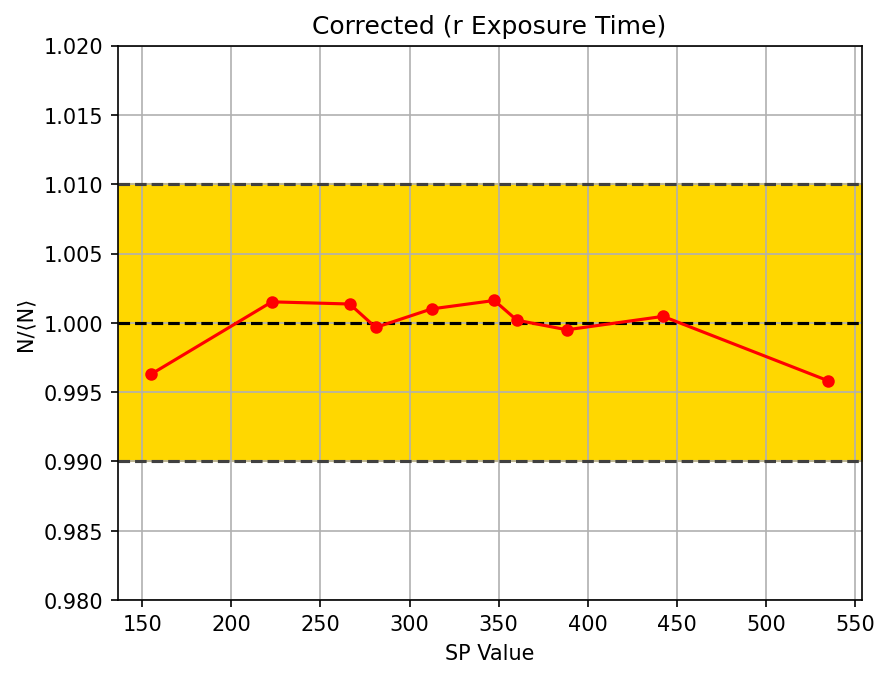

In [24]:
oneMap = condMaps[Config.exptimeSUMr]

numBinsTest = 10
binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = detStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
#plt.fill_between(plt.gca().get_xlim(), 0.98, 1.02, color = (176/256,141/256,87/256))
#plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = (192/256,192/256,192/256))
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.ylim([0.98, 1.02])
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Corrected (r Exposure Time)')
plt.grid(zorder = 0)
plt.show()

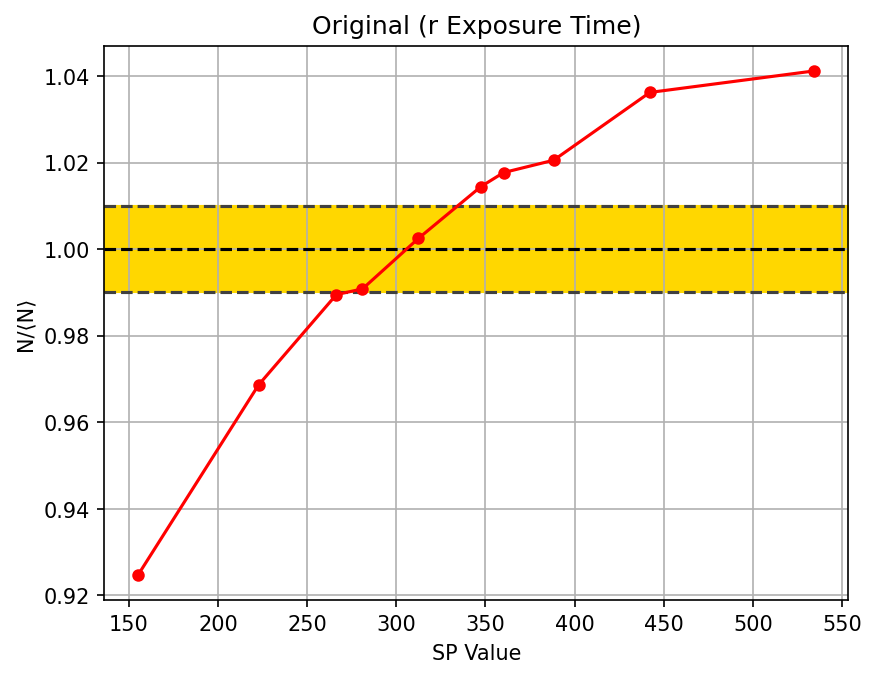

In [25]:
oneMap = condMaps[Config.exptimeSUMr]

binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = originalDetStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
# plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'silver')
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Original (r Exposure Time)')
plt.grid(zorder = 0)
plt.show()

In [26]:
# errorReduction = []

# for cond in condMaps:
    
#     oneMap = cond
    
#     binIndLims = [0]

#     for i in range(numBinsTest):
#         binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

#     sortInds = oneMap.argsort()
#     oneMap = oneMap[sortInds[::1]]
#     corDetStarTemp = detStar[sortInds[::1]]
#     orgDetStarTemp = originalDetStar[sortInds[::1]]
#     injStarTemp = injStar[sortInds[::1]]

#     corDetBins = []
#     orgDetBins = []
#     injBins = []
#     mapBins = []

#     for i in range(numBinsTest):
#         corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
#         orgDetBins.append(orgDetStarTemp[binIndLims[i]:binIndLims[i+1]])
#         injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
#         mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

#     yValuesCor = []
#     yValuesOrg = []
#     xValues = []

#     for i in range(numBinsTest):
#         yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)
#         yValuesOrg.append((np.sum(orgDetBins[i]) / np.sum(injBins[i])) / aveEff)
#         xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

#     xValues = np.array(xValues)
#     yValuesCor = np.array(yValuesCor)
#     yValuesOrg = np.array(yValuesOrg)
    
#     errorReduction.append(np.sum(np.abs(yValuesOrg - 1)) / np.sum(np.abs(yValuesCor - 1)))

In [27]:
# errorReduction = np.array(errorReduction)

In [28]:
# plt.figure(dpi = 125)
# plt.hist(errorReduction, bins = 50)
# plt.grid()
# plt.show()

In [29]:
# print(np.min(errorReduction))
# print(np.max(errorReduction))
# print(np.average(errorReduction))

In [30]:
aveError = []

for cond in condMaps:
    
    oneMap = cond
    
    binIndLims = [0]

    for i in range(numBinsTest):
        binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

    sortInds = oneMap.argsort()
    corDetStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    corDetBins = []
    injBins = []

    for i in range(numBinsTest):
        corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
        injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])

    yValuesCor = []

    for i in range(numBinsTest):
        yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)

    yValuesCor = np.array(yValuesCor)
    
    aveError.append(np.average(np.abs(yValuesCor - 1)))

In [31]:
aveError = np.array(aveError)

In [32]:
np.average(aveError)

0.0022916008618510736

In [33]:
# maxError[Config.exptimeSUMi]

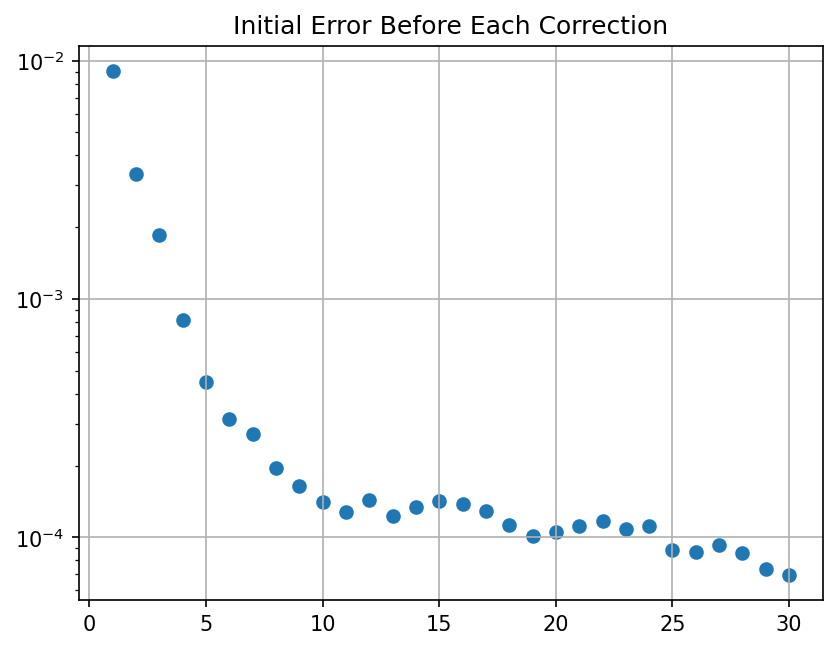

In [34]:
plt.figure(dpi = 150)
plt.scatter(np.arange(len(allErrors)) + 1, allErrors)
plt.yscale('log')
plt.grid()
plt.title('Initial Error Before Each Correction')
plt.show()

# COMMENT OUT THIS CODE, MEANT TO BE TEMPORARY

In [35]:
# iterations

In [36]:
# len(trimRedMaps)

In [37]:
# allErrorsExtra = []
    
# while len(trimRedMaps) > 0:

#     index = mostSigPCMap(trimRedMaps, detStar)

#     degree, error = findBestDegree(index, trimRedMaps, detStar)

#     allErrorsExtra.append(error)

#     # plotNoFit(index, trimRedMaps, detStar, size = 75)
#     # print(degree)

#     fitParams = getFitParams(index, trimRedMaps, detStar, fitDegree = degree)

#     correction = np.full(len(detStar), 0.0)

#     for i in range(len(fitParams)):
#         correction = correction + (fitParams[i] * (trimRedMaps[index]**(len(fitParams) - 1 - i)))

#     correction = 1 / correction

#     detStar = detStar * correction

#     # plotNoFit(index, trimRedMaps, detStar)

#     pcMapCutoff = np.full(len(trimRedMaps), True, dtype = bool)
#     pcMapCutoff[index] = False
#     trimRedMaps = trimRedMaps[pcMapCutoff]

# allErrorsExtra = np.array(allErrorsExtra)

In [38]:
# aveError = []

# for cond in condMaps:
    
#     oneMap = cond
    
#     binIndLims = [0]

#     for i in range(numBinsTest):
#         binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

#     sortInds = oneMap.argsort()
#     corDetStarTemp = detStar[sortInds[::1]]
#     injStarTemp = injStar[sortInds[::1]]

#     corDetBins = []
#     injBins = []

#     for i in range(numBinsTest):
#         corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
#         injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])

#     yValuesCor = []

#     for i in range(numBinsTest):
#         yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)

#     yValuesCor = np.array(yValuesCor)
    
#     aveError.append(np.average(np.abs(yValuesCor - 1)))

In [39]:
# aveError = np.array(aveError)

In [40]:
# np.average(aveError)

In [41]:
# everyError = []

# for error in allErrors:
#     everyError.append(error)
# for error in allErrorsExtra:
#     everyError.append(error)
    
# everyError = np.array(everyError)

In [42]:
# plt.figure(dpi = 150)
# plt.scatter(np.arange(len(everyError)) + 1, everyError)
# plt.yscale('log')
# plt.grid()
# plt.title('Initial Error Before Each Correction')
# plt.show()

In [43]:
maxError = []

for cond in condMaps:
    
    oneMap = cond
    
    binIndLims = [0]

    for i in range(numBinsTest):
        binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

    sortInds = oneMap.argsort()
    corDetStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    corDetBins = []
    injBins = []

    for i in range(numBinsTest):
        corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
        injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])

    yValuesCor = []

    for i in range(numBinsTest):
        yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)

    yValuesCor = np.array(yValuesCor)
    
    maxError.append(np.max(np.abs(yValuesCor - 1)))

In [44]:
maxError = np.array(maxError)

In [45]:
np.max(maxError)

0.012376079243680449

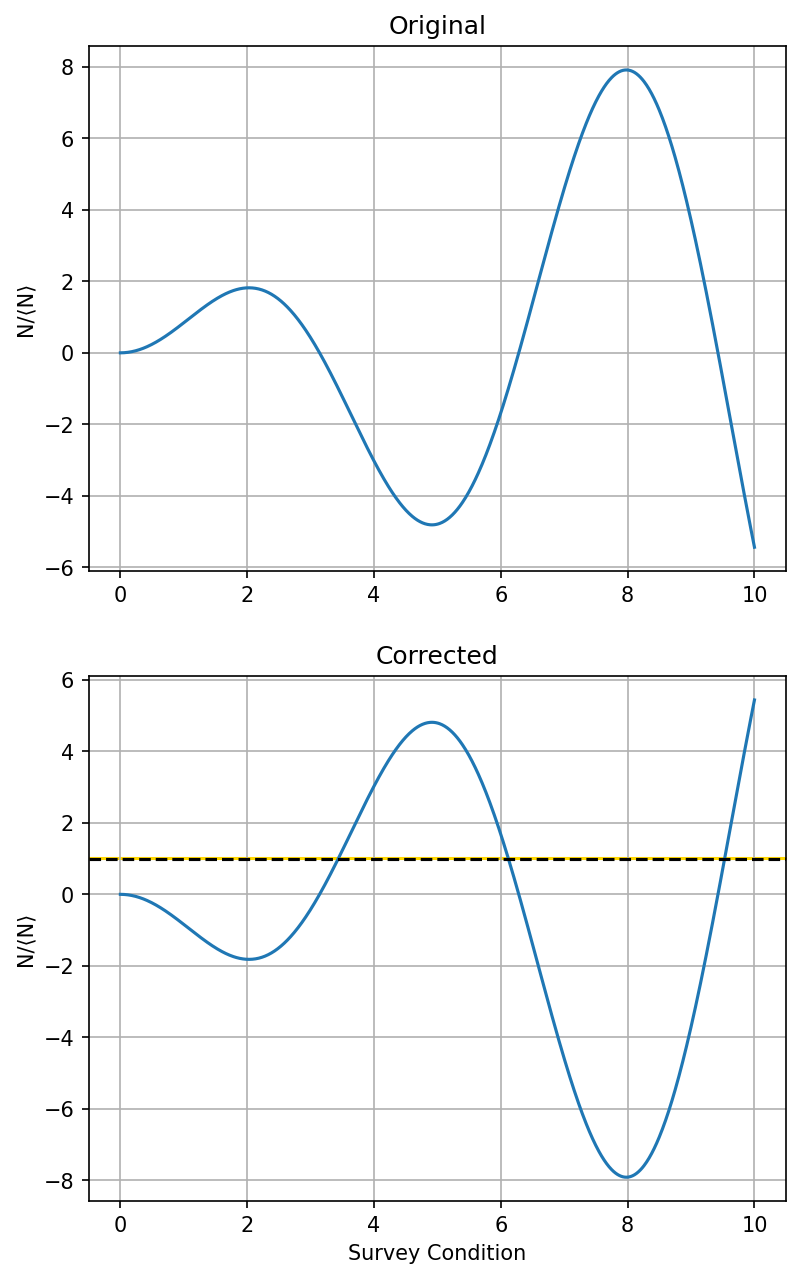

In [46]:
x = np.linspace(0, 10, 1000)
y = x * np.sin(x)

fig, axs = plt.subplots(2, dpi = 150, figsize = (6, 10))
axs[0].grid()
axs[0].set_title('Original')
axs[0].set_ylabel('N/⟨N⟩')
#axs[0].label_outer()
axs[0].plot(x, y)
axs[1].grid()
axs[1].set_ylabel('N/⟨N⟩')
axs[1].set_title('Corrected')
axs[1].set_xlabel('Survey Condition')
axs[1].plot(x, -y)
axs[1].axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
axs[1].set_xlim(axs[1].get_xlim())
axs[1].fill_between(axs[1].get_xlim(), 0.99, 1.01, color = 'gold')
fig.patch.set_facecolor('white')
plt.savefig('Corrections/test space.png', bbox_inches='tight')
plt.show()